## 문제 1
_01_code/_15_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py 실행결과 제시, Wandb URL #1 \
_01_code/_15_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py 실행결과 제시, 출력 그래프 제시 \
_01_code/_15_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py 실행결과 제시, Wandb URL #2 \
_01_code/_15_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py 실행결과 제시

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
from matplotlib import pyplot as plt
import os
import wandb
from pathlib import Path

from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._14_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, CryptoCurrencyDataset
from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer

BASE_PATH = "./_01_code/_15_lstm_and_its_application" # BASE_PATH: /Users/yhhan/git/link_dl
CHECKPOINT_FILE_PATH = os.path.join(BASE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(BASE_PATH, "checkpoints"))

In [2]:
def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True, config=None):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  # print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape, "!!! - 1")

  # X_train.shape: [3212, 10, 5]
  # X_validation.shape: [100, 10, 5]
  # X_test.shape: [10, 10, 5]
  # y_train.shape: [3212]
  # y_validation.shape: [100]
  # y_test.shape: [10]

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  if config:
    train_data_loader = DataLoader(
      dataset=train_crypto_currency_dataset, batch_size=config["batch_size"], shuffle=True
    )
    validation_data_loader = DataLoader(
      dataset=validation_crypto_currency_dataset, batch_size=config["batch_size"], shuffle=True
    )
    test_data_loader = DataLoader(
      dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )
  else:
    train_data_loader = DataLoader(
      dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    validation_data_loader = DataLoader(
      dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    test_data_loader = DataLoader(
      dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )

  return train_data_loader, validation_data_loader, test_data_loader

_01_code/_15_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py

In [3]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
      self.fcn = nn.Linear(in_features=128, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args(args=[])
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: cudje (cudje-cudje). Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 10.20037, V_loss: 79.71881, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.006
[Epoch  30] T_loss: 5.99404, V_loss: 46.31964, V_loss decreased (79.71881 --> 46.31964). Saving model... | T_time: 00:00:01, T_speed: 0.710
[Epoch  60] T_loss: 0.65166, V_loss: 11.13410, V_loss decreased (46.31964 --> 11.13410). Saving model... | T_time: 00:00:01, T_speed: 0.072
[Epoch  90] T_loss: 0.37324, V_loss: 7.40732, V_loss decreased (11.13410 --> 7.40732). Saving model... | T_time: 00:00:02, T_speed: 0.143
[Epoch 120] T_loss: 0.26639, V_loss: 5.32899, V_loss decreased (7.40732 --> 5.32899). Saving model... | T_time: 00

Epoch,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
Training loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁█▁▁▁▂▂▂▂▂▂▃▇▃▃█▂▅▂▃▂▃▅▄▃▂▃▅▂▃▄▅▃
Validation loss,█▅▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3690
Training loss,0.01034
Training speed (epochs/sec.),4.98501
Validation loss,0.5232


_01_code/_15_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py

MODEL FILE: ./_01_code/_15_lstm_and_its_application/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_194393/3869782121.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu'

[TEST DATA]
 0: 1,090.51 <--> 1,390.43 (Loss:        299.92)
 1: 1,087.46 <--> 1,319.45 (Loss:        231.99)
 2: 1,097.67 <--> 1,378.05 (Loss:        280.38)
 3: 1,094.06 <--> 1,373.29 (Loss:        279.23)
 4: 1,089.19 <--> 1,380.87 (Loss:        291.68)
 5: 1,094.37 <--> 1,331.62 (Loss:        237.25)
 6: 1,098.03 <--> 1,284.38 (Loss:        186.35)
 7: 1,095.79 <--> 1,360.09 (Loss:        264.31)
 8: 1,094.43 <--> 1,334.58 (Loss:        240.15)
 9: 1,099.67 <--> 1,302.60 (Loss:        202.94)


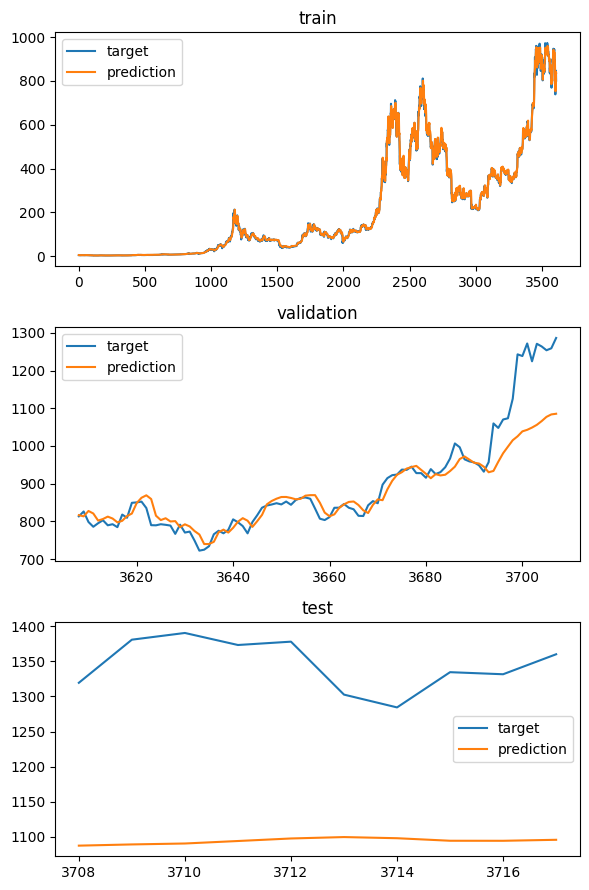

In [4]:
def testReg(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  testReg(test_model)
  predict_all(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args(args=[])
  main(args)


_01_code/_15_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py

In [5]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
      self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args(args=[])
  main(args)
  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69183, T_accuracy: 52.7993 | V_loss: 0.69036, V_accuracy: 56.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69055, T_accuracy: 53.1874 | V_loss: 0.69764, V_accuracy: 44.0000 | Early stopping counter: 1 out of 30 | T_time: 00:00:00, T_speed: 0.000
[Epoch  60] T_loss: 0.69080, T_accuracy: 53.1042 | V_loss: 0.69819, V_accuracy: 44.0000 | Early stopping counter: 2 out of 30 | T_time: 00:00:01, T_speed: 60.000
[Epoch  90] T_loss: 0.69063, T_accuracy: 53.1042 | V_loss: 0.69780, V_accuracy: 44.0000 | Early stopping counter: 3 out of 30 | T_time: 00:00:02, T_speed: 45.000
[Epoc

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇███
Training loss,██████████████████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁
Training speed (epochs/sec.),▁▁█▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Validation accuracy (%),▇▁▁▁▁▁▁▁▁▁▁▁▇█▇█▆█▇▆▅▃▆█▇▆▅▆▄▄▅▅▄▃▂▄▂▂▂▂
Validation loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▅▅▅▅▆▇▇███
Epoch,1380
Training accuracy (%),62.11197
Training loss,0.58669
Training speed (epochs/sec.),32.85714
Validation accuracy (%),46


_01_code/_15_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py

In [6]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args(args=[])
  main(args)


MODEL FILE: ./_01_code/_15_lstm_and_its_application/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_194393/1144575016.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu'

[TEST DATA]
TEST RESULTS: 60.000%
 0:   0.00 <-->   0.00
 1:   0.00 <-->   0.00
 2:   0.00 <-->   1.00
 3:   0.00 <-->   0.00
 4:   0.00 <-->   1.00
 5:   1.00 <-->   1.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   1.00
 8:   0.00 <-->   1.00
 9:   1.00 <-->   1.00


## 문제2
##### 적절한 새로운 모델 구성 및 하이퍼파라미터 찾기
학습 데이터 관련 설정 값 고정

In [7]:
parser = get_parser()
args = parser.parse_args(args=[])
args.epochs = 10_000
args.batch_size = 256
args.validation_intervals = 30
args.learning_rate = 1e-4
args.early_stop_patience = 20
args.early_stop_delta = 0.000001
args.weight_decay = 0.0

config = {
'epochs': args.epochs,
'batch_size': args.batch_size,
'validation_intervals': args.validation_intervals,
'learning_rate': args.learning_rate,
'early_stop_patience': args.early_stop_patience,
'early_stop_delta': args.early_stop_delta,
'weight_decay': args.weight_decay
}

train_data_loader, validation_data_loader, test_data_loader = get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True, config=config)
btrain_data_loader, bvalidation_data_loader, btest_data_loader = get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=False, config=config)

### 가장 학습이 잘 되는 모델 구성 및 하이퍼파라미터 값을 찾아 제시

##### 파라미터 변경 값 제시
MyModel = layer 수를 2개에서 6개로 증가\
lstm에 dropout을 적용(0.05)\
linear layer 이전 activate func 및 BatchNorm 계산을 추가하였음\
batch_size를 1024에서 512로 감소\
early stopping counter를 30에서 20으로 감소

In [8]:
def get_my_model(n_input=5, n_output=1):
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()
      
      self.lstm1 = nn.LSTM(input_size=n_input, hidden_size=32, num_layers=1, 
                            batch_first=True, bidirectional=True, dropout=0.4)
      self.fc1 = nn.Linear(64, 32)
      self.fc2 = nn.Linear(32, n_output)

    def forward(self, x):
      lstm_out, _ = self.lstm1(x)
      x = lstm_out[:, -1, :]
      
      x = self.fc1(x)
      x = self.fc2(x)
      return x

  my_model = MyModel(n_input=n_input, n_output=n_output)

  return my_model

In [9]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

project_name = "lstm_regression_btc_krw"
wandb.init(
  mode="online" if args.wandb else "disabled",
  project=project_name,
  notes="btc_krw experiment with lstm",
  tags=["lstm", "regression", "btc_krw"],
  name=run_time_str,
  config=config
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_my_model(n_input=5, n_output=1)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)


regression_trainer = RegressionTrainer(
  project_name, model, optimizer, train_data_loader, validation_data_loader, None,
  run_time_str, wandb, device, CHECKPOINT_FILE_PATH
)
regression_trainer.train_loop()

wandb.finish()

/home/cuj/Python/environments/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch   1] T_loss: 8.69882, V_loss: 69.00441, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.017
[Epoch  30] T_loss: 0.37798, V_loss: 6.62672, V_loss decreased (69.00441 --> 6.62672). Saving model... | T_time: 00:00:01, T_speed: 0.065
[Epoch  60] T_loss: 0.03238, V_loss: 0.26842, V_loss decreased (6.62672 --> 0.26842). Saving model... | T_time: 00:00:03, T_speed: 1.892
[Epoch  90] T_loss: 0.01989, V_loss: 0.13151, V_loss decreased (0.26842 --> 0.13151). Saving model... | T_time: 00:00:04, T_speed: 0.180
[Epoch 120] T_loss: 0.01797, V_loss: 0.11012, V_loss decreased (0.13151 --> 0.11012). Saving model... | T_time: 00:00:05, T_speed: 0.125
[Epoch 150] T_loss: 0.01689, V_loss: 0.09770, V_loss decreased (0.11012 --> 0.09770). Saving model... | T_time: 00:00:07, T_speed: 0.283
[Epoch 180] T_loss: 0.01604, V_loss: 0.08996, V_loss decreased (0.09770 --> 0.08996). Saving model... | T_time: 00:00:09, T_speed: 230.179
[Epoch 210] T_loss: 0.01529, V_loss: 0.08467, V_loss decreased (0.0

Epoch,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,1950
Training loss,0.00991
Training speed (epochs/sec.),5.04451
Validation loss,0.05101


/home/cuj/Python/environments/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/tmp/ipykernel_194393/1806298228.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serial

MODEL FILE: ./_01_code/_15_lstm_and_its_application/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 1,128.97 <--> 1,271.21 (Loss:        142.24)
 1: 997.05 <--> 1,070.26 (Loss:         73.21)
 2: 1,165.00 <--> 1,334.58 (Loss:        169.58)
 3: 954.52 <--> 948.70 (Loss:          5.82)
 4: 1,199.14 <--> 1,331.62 (Loss:        132.48)
 5: 960.34 <--> 1,047.88 (Loss:         87.53)
 6: 1,188.92 <--> 1,390.43 (Loss:        201.51)
 7: 953.61 <--> 959.09 (Loss:          5.48)
 8: 1,235.95 <--> 1,378.05 (Loss:        142.10)
 9: 941.04 <--> 931.83 (Loss:          9.20)
10: 942.95 <--> 956.43 (Loss:         13.48)
11: 1,158.38 <--> 1,264.13 (Loss:        105.75)
12: 1,023.67 <--> 1,073.52 (Loss:         49.86)
13: 1,176.03 <--> 1,319.45 (Loss:        143.42)
14: 1,216.87 <--> 1,360.09 (Loss:        143.23)
15: 1,085.01 <--> 1,272.01 (Loss:        187.00)
16: 924.45 <--> 957.10 (Loss:         32.65)
17: 1,049.40 <--> 1,243.20 (Loss:        193.79)
18: 1,190.88 <--> 1,3

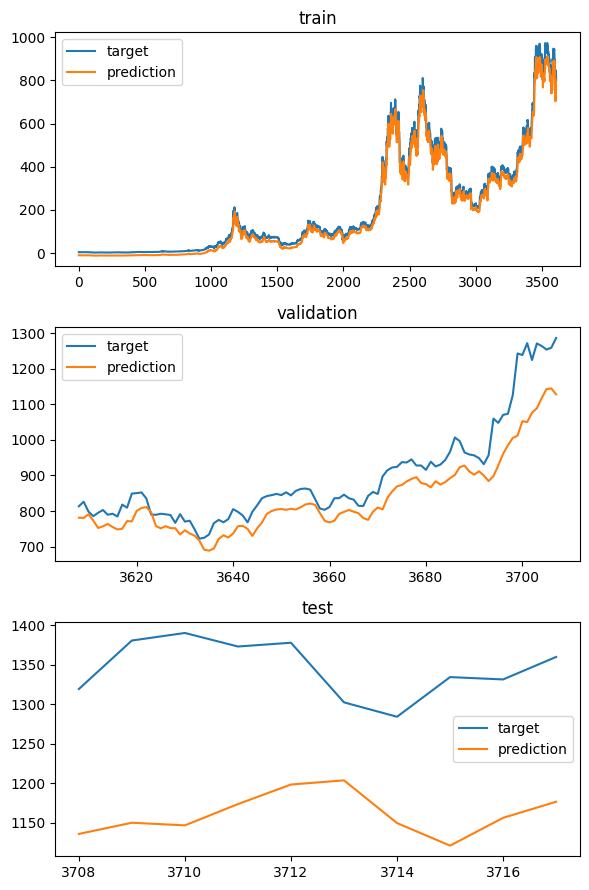

In [10]:
def testReg(test_model):
  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

project_name = "lstm_regression_btc_krw"
wandb.init(
  mode="disabled",
  project=project_name,
  notes="btc_krw experiment with lstm",
  tags=["lstm", "regression", "btc_krw"],
  name=run_time_str,
  config=config
)

test_model = get_my_model(n_input=5, n_output=1)

project_name = "lstm_regression_btc_krw"
latest_file_path = os.path.join(
  CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
)
print("MODEL FILE: {0}".format(latest_file_path))
test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

testReg(test_model)
predict_all(test_model)

In [11]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

project_name = "lstm_classification_btc_krw"
wandb.init(
  mode="online" if args.wandb else "disabled",
  project=project_name,
  notes="btc_krw experiment with lstm",
  tags=["lstm", "classification", "btc_krw"],
  name=run_time_str,
  config=config
)
print(args)
print(wandb.config)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}.")

model = get_my_model(n_input=5, n_output=2)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

classification_trainer = ClassificationTrainer(
  project_name, model, optimizer, btrain_data_loader, bvalidation_data_loader, None,
  run_time_str, wandb, device, CHECKPOINT_FILE_PATH
)
classification_trainer.train_loop()

wandb.finish()

Namespace(wandb=True, batch_size=256, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=20, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 256, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 20, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.70211, T_accuracy: 47.0371 | V_loss: 0.72022, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000


/home/cuj/Python/environments/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 0.69065, T_accuracy: 53.1046 | V_loss: 0.69375, V_accuracy: 47.3333 | V_loss decreased (0.72022 --> 0.69375). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69055, T_accuracy: 53.0763 | V_loss: 0.69383, V_accuracy: 47.3333 | Early stopping counter: 1 out of 20 | T_time: 00:00:02, T_speed: 30.000
[Epoch  90] T_loss: 0.69051, T_accuracy: 53.2180 | V_loss: 0.69385, V_accuracy: 47.3333 | Early stopping counter: 2 out of 20 | T_time: 00:00:04, T_speed: 22.500
[Epoch 120] T_loss: 0.69035, T_accuracy: 53.1330 | V_loss: 0.69388, V_accuracy: 47.3333 | Early stopping counter: 3 out of 20 | T_time: 00:00:05, T_speed: 24.000
[Epoch 150] T_loss: 0.69041, T_accuracy: 53.1330 | V_loss: 0.69342, V_accuracy: 48.0000 | V_loss decreased (0.69375 --> 0.69342). Saving model... | T_time: 00:00:07, T_speed: 21.429
[Epoch 180] T_loss: 0.69034, T_accuracy: 53.0763 | V_loss: 0.69355, V_accuracy: 48.0000 | Early stopping counter: 1 out of 20 | T_time: 00:00:08, T_sp

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
Training accuracy (%),▁▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇██████
Training loss,█▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Training speed (epochs/sec.),▁██▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Validation accuracy (%),▃▃▃▃▃▃▄▃▃▄▃▃▅▅▆▆▆▆▆▆▇▇████████▆▅▄▁▁▂▃▂▃▁
Validation loss,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▅▆▆▇█
Epoch,1470
Training accuracy (%),55.14602
Training loss,0.68072
Training speed (epochs/sec.),20.41667
Validation accuracy (%),45.33333


In [12]:
def test(test_model):
  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in btest_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_my_model(n_input=5, n_output=2)

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)


if __name__ == "__main__":
  main(args)


MODEL FILE: ./_01_code/_15_lstm_and_its_application/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 46.667%
 0:   0.00 <-->   1.00
 1:   0.00 <-->   1.00
 2:   0.00 <-->   0.00
 3:   1.00 <-->   1.00
 4:   0.00 <-->   0.00
 5:   1.00 <-->   0.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   1.00
 8:   0.00 <-->   0.00
 9:   1.00 <-->   0.00
10:   0.00 <-->   0.00
11:   0.00 <-->   1.00
12:   0.00 <-->   1.00
13:   0.00 <-->   1.00
14:   1.00 <-->   0.00
15:   0.00 <-->   0.00
16:   0.00 <-->   1.00
17:   1.00 <-->   1.00
18:   0.00 <-->   0.00
19:   1.00 <-->   1.00
20:   0.00 <-->   0.00
21:   0.00 <-->   1.00
22:   0.00 <-->   1.00
23:   0.00 <-->   1.00
24:   0.00 <-->   1.00
25:   0.00 <-->   0.00
26:   0.00 <-->   1.00
27:   0.00 <-->   0.00
28:   0.00 <-->   1.00
29:   0.00 <-->   0.00


/home/cuj/Python/environments/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/tmp/ipykernel_194393/1726902618.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serial

## 문제3
##### 데이터 feature 추가 후 성능 변화 확인하기
학습 데이터 관련 설정 값은 고정하게 유지하며 데이터 feature에 next_open 추가하기

In [13]:
import pandas as pd

In [14]:
def get_cryptocurrency_data_modifier(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
  btc_krw_path = "BTC_KRW.csv"#os.path.join(BASE_PATH, "_00_data", "k_cryptocurrency", "BTC_KRW.csv")
  df = pd.read_csv(btc_krw_path)
  row_size = len(df)
  # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
  date_list = df['Date']
  
  df['next_open'] = df['Open'].shift(-1)

  df = df.drop(columns=['Date'])
  df = df.dropna()

  row_size = len(df)
  data_size = row_size - sequence_size
  train_size = data_size - (validation_size + test_size)
  #################################################################################################

  row_cursor = 0

  X_train_list = []
  y_train_regression_list = []
  y_train_classification_list = []
  y_train_date = []
  for idx in range(0, train_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_train_list.append(torch.from_numpy(sequence_data))
    y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_train_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_train_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_train = torch.stack(X_train_list, dim=0).to(torch.float)
  y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
  y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

  m = X_train.mean(dim=0, keepdim=True)
  s = X_train.std(dim=0, keepdim=True)
  X_train = (X_train - m) / s

  #################################################################################################

  X_validation_list = []
  y_validation_regression_list = []
  y_validation_classification_list = []
  y_validation_date = []
  for idx in range(row_cursor, row_cursor + validation_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_validation_list.append(torch.from_numpy(sequence_data))
    y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_validation_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_validation_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
  y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
  y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

  X_validation = (X_validation - m) / s
  #################################################################################################

  X_test_list = []
  y_test_regression_list = []
  y_test_classification_list = []
  y_test_date = []
  for idx in range(row_cursor, row_cursor + test_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_test_list.append(torch.from_numpy(sequence_data))
    y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_test_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_test_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_test = torch.stack(X_test_list, dim=0).to(torch.float)
  y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
  y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

  X_test = (X_test - m) / s

  if is_regression:
    return (
      X_train, X_validation, X_test,
      y_train_regression, y_validation_regression, y_test_regression,
      y_train_date, y_validation_date, y_test_date
    )
  else:
    return (
      X_train, X_validation, X_test,
      y_train_classification, y_validation_classification, y_test_classification,
      y_train_date, y_validation_date, y_test_date
    )

In [15]:
def get_btc_krw_data_modifier(sequence_size=10, validation_size=100, test_size=10, is_regression=True, config=None):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data_modifier(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  # print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape, "!!! - 1")

  # X_train.shape: [3212, 10, 5]
  # X_validation.shape: [100, 10, 5]
  # X_test.shape: [10, 10, 5]
  # y_train.shape: [3212]
  # y_validation.shape: [100]
  # y_test.shape: [10]

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  if config:
    train_data_loader = DataLoader(
      dataset=train_crypto_currency_dataset, batch_size=config["batch_size"], shuffle=True
    )
    validation_data_loader = DataLoader(
      dataset=validation_crypto_currency_dataset, batch_size=config["batch_size"], shuffle=True
    )
    test_data_loader = DataLoader(
      dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )
  else:
    train_data_loader = DataLoader(
      dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    validation_data_loader = DataLoader(
      dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    test_data_loader = DataLoader(
      dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )

  return train_data_loader, validation_data_loader, test_data_loader

In [16]:
parser = get_parser()
args = parser.parse_args(args=[])
args.epochs = 10_000
args.batch_size = 256
args.validation_intervals = 30
args.learning_rate = 1e-4
args.early_stop_patience = 20
args.early_stop_delta = 0.000001
args.weight_decay = 0.0

config = {
'epochs': args.epochs,
'batch_size': args.batch_size,
'validation_intervals': args.validation_intervals,
'learning_rate': args.learning_rate,
'early_stop_patience': args.early_stop_patience,
'early_stop_delta': args.early_stop_delta,
'weight_decay': args.weight_decay
}

train_data_loader, validation_data_loader, test_data_loader = get_btc_krw_data_modifier(sequence_size=21, validation_size=150, test_size=30, is_regression=True, config=config)
btrain_data_loader, bvalidation_data_loader, btest_data_loader = get_btc_krw_data_modifier(sequence_size=21, validation_size=150, test_size=30, is_regression=False, config=config)

next_open이 추가된 후 성능 보기

In [17]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

project_name = "lstm_regression_btc_krw"
wandb.init(
  mode="online" if args.wandb else "disabled",
  project=project_name,
  notes="btc_krw experiment with lstm",
  tags=["lstm", "regression", "btc_krw"],
  name=run_time_str,
  config=config
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_my_model(n_input=6, n_output=1)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)


regression_trainer = RegressionTrainer(
  project_name, model, optimizer, train_data_loader, validation_data_loader, None,
  run_time_str, wandb, device, CHECKPOINT_FILE_PATH
)
regression_trainer.train_loop()

wandb.finish()


/home/cuj/Python/environments/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch   1] T_loss: 9.77993, V_loss: 73.97870, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.020
[Epoch  30] T_loss: 0.33485, V_loss: 6.15135, V_loss decreased (73.97870 --> 6.15135). Saving model... | T_time: 00:00:01, T_speed: 0.073
[Epoch  60] T_loss: 0.03099, V_loss: 0.25076, V_loss decreased (6.15135 --> 0.25076). Saving model... | T_time: 00:00:02, T_speed: 0.073
[Epoch  90] T_loss: 0.02119, V_loss: 0.15037, V_loss decreased (0.25076 --> 0.15037). Saving model... | T_time: 00:00:04, T_speed: 0.272
[Epoch 120] T_loss: 0.01938, V_loss: 0.13927, V_loss decreased (0.15037 --> 0.13927). Saving model... | T_time: 00:00:05, T_speed: 0.162
[Epoch 150] T_loss: 0.01814, V_loss: 0.12779, V_loss decreased (0.13927 --> 0.12779). Saving model... | T_time: 00:00:07, T_speed: 0.995
[Epoch 180] T_loss: 0.01695, V_loss: 0.11780, V_loss decreased (0.12779 --> 0.11780). Saving model... | T_time: 00:00:08, T_speed: 0.274
[Epoch 210] T_loss: 0.01610, V_loss: 0.10887, V_loss decreased (0.117

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▂▁▁▁▁▁▁▁▃▁▁▁▁▂█▁▁▁▁▁▁▁▁▁▁▂▁▃▁▁▁▂▁▁
Validation loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,1470
Training loss,0.01
Training speed (epochs/sec.),2.45837
Validation loss,0.05496


/home/cuj/Python/environments/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/tmp/ipykernel_194393/247243800.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seriali

MODEL FILE: ./_01_code/_15_lstm_and_its_application/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 966.90 <--> 1,047.88 (Loss:         80.97)
 1: 945.19 <--> 931.83 (Loss:         13.35)
 2: 1,093.02 <--> 1,272.01 (Loss:        178.99)
 3: 951.77 <--> 956.43 (Loss:          4.66)
 4: 1,202.28 <--> 1,334.58 (Loss:        132.30)
 5: 955.23 <--> 948.70 (Loss:          6.53)
 6: 1,231.24 <--> 1,331.62 (Loss:        100.37)
 7: 1,217.77 <--> 1,284.38 (Loss:         66.61)
 8: 1,142.96 <--> 1,271.21 (Loss:        128.26)
 9: 1,257.06 <--> 1,302.60 (Loss:         45.54)
10: 945.25 <--> 1,059.85 (Loss:        114.60)
11: 1,177.01 <--> 1,264.13 (Loss:         87.12)
12: 1,028.87 <--> 1,073.52 (Loss:         44.65)
13: 1,196.19 <--> 1,286.65 (Loss:         90.46)
14: 931.38 <--> 957.10 (Loss:         25.71)
15: 1,221.80 <--> 1,380.87 (Loss:        159.07)
16: 1,202.03 <--> 1,259.24 (Loss:         57.21)
17: 971.52 <--> 996.63 (Loss:         25.11)
18: 1,225.53 <--> 1,3

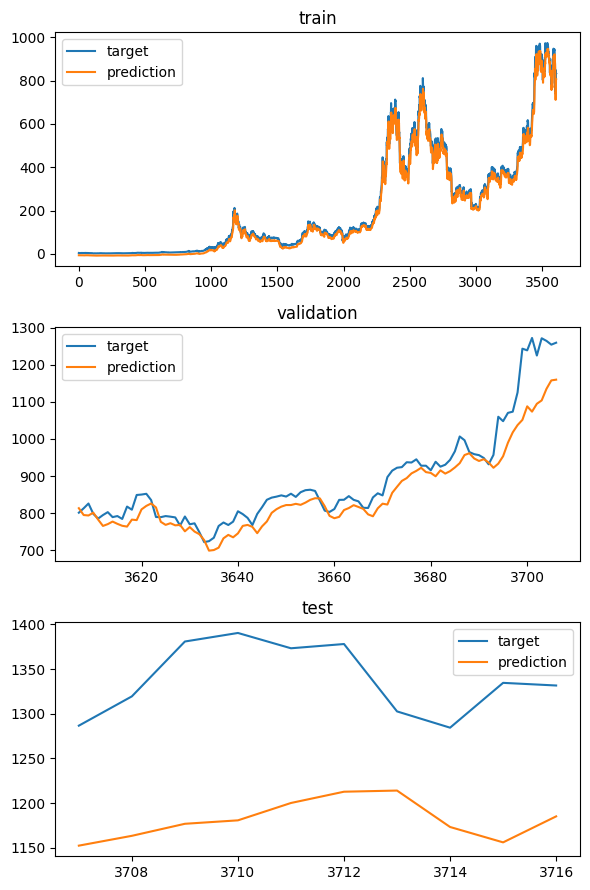

In [18]:
def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data_modifier(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

project_name = "lstm_regression_btc_krw"
wandb.init(
  mode="disabled",
  project=project_name,
  notes="btc_krw experiment with lstm",
  tags=["lstm", "regression", "btc_krw"],
  name=run_time_str,
  config=config
)

test_model = get_my_model(n_input=6, n_output=1)

project_name = "lstm_regression_btc_krw"
latest_file_path = os.path.join(
  CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
)
print("MODEL FILE: {0}".format(latest_file_path))
test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

testReg(test_model)
predict_all(test_model)

In [19]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

project_name = "lstm_classification_btc_krw"
wandb.init(
  mode="online" if args.wandb else "disabled",
  project=project_name,
  notes="btc_krw experiment with lstm",
  tags=["lstm", "classification", "btc_krw"],
  name=run_time_str,
  config=config
)
print(args)
print(wandb.config)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}.")

model = get_my_model(n_input=6, n_output=2)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

classification_trainer = ClassificationTrainer(
  project_name, model, optimizer, btrain_data_loader, bvalidation_data_loader, None,
  run_time_str, wandb, device, CHECKPOINT_FILE_PATH
)
classification_trainer.train_loop()

wandb.finish()

Namespace(wandb=True, batch_size=256, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=20, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 256, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 20, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69286, T_accuracy: 52.9495 | V_loss: 0.69139, V_accuracy: 53.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000


/home/cuj/Python/environments/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch  30] T_loss: 0.69063, T_accuracy: 53.4600 | V_loss: 0.69674, V_accuracy: 46.6667 | Early stopping counter: 1 out of 20 | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69039, T_accuracy: 53.0913 | V_loss: 0.69565, V_accuracy: 46.6667 | Early stopping counter: 2 out of 20 | T_time: 00:00:02, T_speed: 30.000
[Epoch  90] T_loss: 0.69048, T_accuracy: 53.1480 | V_loss: 0.69481, V_accuracy: 46.6667 | Early stopping counter: 3 out of 20 | T_time: 00:00:04, T_speed: 22.500
[Epoch 120] T_loss: 0.69034, T_accuracy: 53.3182 | V_loss: 0.69491, V_accuracy: 46.6667 | Early stopping counter: 4 out of 20 | T_time: 00:00:05, T_speed: 24.000
[Epoch 150] T_loss: 0.69038, T_accuracy: 53.2898 | V_loss: 0.69416, V_accuracy: 48.6667 | Early stopping counter: 5 out of 20 | T_time: 00:00:07, T_speed: 21.429
[Epoch 180] T_loss: 0.69021, T_accuracy: 53.3749 | V_loss: 0.69379, V_accuracy: 48.0000 | Early stopping counter: 6 out of 20 | T_time: 00:00:08, T_speed: 22.500
[Epoch 210] T_loss: 0.69046,

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
Training accuracy (%),▁▃▁▂▂▂▃▃▄▃▃▃▃▅▅▄▄▅▅▅▆▅▆▅▅▆▆▅▅▆▆▅▇▇▆▆▇█▇▇
Training loss,█▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▁▁▁▁
Training speed (epochs/sec.),▁██▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Validation accuracy (%),▅▁▁▁▁▂▂▂▂▃▃▃▃▂▅▇▃▆▆▅▆▇▇███▇▇▇█▆▆▇▇▇███▇█
Validation loss,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▃▃▃▄▄▄▅▅▆▆▇█
Epoch,1200
Training accuracy (%),54.76461
Training loss,0.68056
Training speed (epochs/sec.),20.33898
Validation accuracy (%),58


In [20]:
def test(test_model):
  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in btest_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

project_name = "lstm_classification_btc_krw"
wandb.init(
  mode="disabled",
  project=project_name,
  notes="btc_krw experiment with lstm",
  tags=["lstm", "regression", "btc_krw"],
  name=run_time_str,
  config=config
)

test_model = get_my_model(n_input=6, n_output=2)

latest_file_path = os.path.join(
  CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
)
print("MODEL FILE: {0}".format(latest_file_path))
test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

test(test_model)

MODEL FILE: ./_01_code/_15_lstm_and_its_application/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 46.667%
 0:   0.00 <-->   1.00
 1:   0.00 <-->   0.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   1.00
 4:   0.00 <-->   0.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   1.00
 7:   0.00 <-->   1.00
 8:   0.00 <-->   0.00
 9:   0.00 <-->   0.00
10:   1.00 <-->   0.00
11:   0.00 <-->   0.00
12:   0.00 <-->   0.00
13:   1.00 <-->   0.00
14:   1.00 <-->   1.00
15:   0.00 <-->   1.00
16:   0.00 <-->   1.00
17:   1.00 <-->   0.00
18:   0.00 <-->   0.00
19:   0.00 <-->   1.00
20:   0.00 <-->   1.00
21:   1.00 <-->   1.00
22:   0.00 <-->   1.00
23:   0.00 <-->   1.00
24:   1.00 <-->   0.00
25:   1.00 <-->   0.00
26:   0.00 <-->   1.00
27:   0.00 <-->   0.00
28:   1.00 <-->   0.00
29:   1.00 <-->   0.00


/home/cuj/Python/environments/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/tmp/ipykernel_194393/2928875446.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serial

### 성능 변화
Regression의 성능은 크게 달라진 점이 없으나 기울기가 완만해지는 것을 육안으로 확인할 수 있었음\
Classification의 성능은 46.7% -> 46.7%로 변화 없음\

성능 변화에 큰 차이가 없는 것은 데이터셋의 "next_open"과 "close" 피처간의 큰 차이가 없어 학습에 도움이 되지 않은 것이라고 생각함

## 숙제 후기
이번 과제를 통해 lstm을 활용하여 bitcoin 가격을 유추하는 모델을 만들어 볼 수 있었습니다.\
하지만 모델을 개발하는 도중 validation 및 testing 과정에서 모델이 유추한 값과 실제 데이터셋의 있는 값이 비슷하여 놀랐지만\
짧은 기간 동안 가격이 오를지, 내릴지를 예측하거나 정확한 가격을 예측하는 것에는 어려움을 느끼는 것을 보아\
아직은 수정할 사항이 많이 있는 것처럼 느껴졌습니다.